*This is a Jupyter Notebook. It is an interactive document that contains both rich text elements such as figures, links, equations, etc. and executable code - in this case Python code (the grey boxes).
**How to use a Jupyter Notebook**: You can execute the blocks of code one at the time by placing the mouse in the grey box and pressing shift + enter. An asterisk will appear in the brackets at the top left of the box while the code is being executed (this may take few seconds) and turns into a number when the execution is over. Alternatively, you can run all the code in the Notebook in a single step by clicking on the menu Cell -> Run All.*

# GSA tutorial - Using GSA to enhance model-informed decisions under uncertainty
Francesca Pianosi, Fanny Sarrazin, Andres Penuela-Fernandez

Mathematical models are often used to inform decision-makers dealing with complex management problems. The model is used to predict the consequences of alternative actions, hence providing a quantitative assessment of their benefits and costs, possibly under different uncertain scenarios. In this context, Global Sensitivity Analysis (GSA) can be used to investigate the space of possible actions in a more comprehensive and structured way, including a range of actions possibly larger than the few ones that decision-makers would test in a traditional 'what-if?' analysis. GSA can also help quantifying the importance of these actions relative to other factors that influence the system response, but that are not controllable and potentially highly uncertain (Ref. 1).


# An epidemiological example

In this Notebook we will use a simple epidemiological model, which provides a mathematical description of the spread of an infectious deasease, such as flu, within a population. 

The **model** divides the population into three "compartments":
* Vulnerable: individuals who are vulnerable but not yet infected with the flu
* Sick: individuals who are infected with the flu
* Immune: individuals who have immunity to the flu. This includes individuals who either have recovered from the flu or have been vaccinated.

The model describes the change in the number of individuals in each compartment over time, using five parameters:
* <font color='blue'>Initial number of vaccinated individuals</font>: people who are immune at the start of the flu season because they were previously vaccinated.
* <font color='blue'>Recovery time</font>: the average number of days to get fully recovered
* <font color='green'>Contact rate per day</font>: number of times that an infected individual comes into contact with a vulnerable individual in a day
* <font color='green'>Contagion ratio</font>: proportion of contacts that result in infection
* <font color='green'>Vaccination rate</font>: number of inviduals who are vaccinated per day during the outbreak

Let's consider the following **decision-making problem**. In a city with a population of 100,000 people, we would like to simulate and compare three possible actions to be taken during the flu season:
* Implementing social distancing measures to reduce the <font color='green'>daily contact rate</font>. A reduction of 0.1 points of this rate is estimated to cost £20,000.
* Distributing face masks to reduce the <font color='green'>contagion rate</font>. Reducing this rate by 0.1 points is estimated to cost £5,000.
* Increasing the <font color='green'>vaccination rate</font> during the flu season. The vaccination cost is of £7 per person.

The objective is to keep the sick population below 25% (25,000 people) at any time, because above this number the healthcare system is overwhelmed; and to do so within the total available budget, which is £300,000. However, the effects of our decisions also depend on <font color='blue'>initial number of vaccinated individuals</font> at the start of the flu season, and the <font color='blue'>recovery time</font>. Both these factors are not known exactly, and it can only be estimated that the number of people initially vaccinated should range between 0 and 50,000 (half of the population), and the recovery time should vary between 7 and 14 days.

## 1 - One-At-the-Time 'what-if?' analysis
In this section, we will run the epidemiological model by changing its parameters one at the time. The goal is to determine a combination of decion-related parameters (contagion ratio, recovery time, vaccination rate) that lead to the desired outputs (that is, to maintain the sick population at peak and the total cost under their respective targets), and that do so under as many combinations as possible of the other two uncertain parameters (initial vaccinated population and recovery time) that are not under our control.

#### Import libraries required to run the model

In [28]:
from __future__ import division, absolute_import, print_function
import sys
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatRangeSlider, IntRangeSlider
import scipy.stats as st
import warnings
warnings.filterwarnings('ignore') # to hide warning messages
import safepython.RSA_thres as RSA_tr # Module that implements RSA
import safepython.plot_functions as pf # Module to visualize the results
from safepython.model_execution import model_execution # Module to execute the model
from safepython.sampling import AAT_sampling, AAT_sampling_extend # Functions to perform the input sampling
from safepython.util import aggregate_boot # Functions to perform bootstrapping
from safepython.util import empiricalcdf
import epi.flu_model as flu_model # Module that simulates the epidemiological model


#### Run the model
We are now ready to run the model. Execute the block of code below, and then use the slider to change the parameter values. Can you determine a combination of decion-related parameters (*contagion ratio*, *recovery time*, *vaccination rate*) that maintain number of sick individuals at peak below **25,000** at all times, for a total cost of less than **£300,000** - under as as many combinations as possible of *initial vaccinated population* and *recovery time*?

In [2]:
Nday = 100 # days
Npop = 100000 # individuals in the total population
target1 =  25000 # target for max number of sick individuals
target2 = 350000 # target for max cost (£)
t = np.linspace(1,Nday,Nday)
def oat_function(contag_ratio = 2, recovery_day = 14, vax_rate=2500,pop_vax_ini = 0, contact_rate = 2):
    # Set a tentative parameterization:
    param = np.array([pop_vax_ini, contact_rate, contag_ratio, recovery_day, vax_rate])    
    # Run simulation:
    
    S, RI, V,max_value,total_cost = flu_model.model(param,t,Npop)
 
    # Plot results:
    plt.figure(figsize=[12,3])
    plt.stackplot(t,S,V,RI,labels=['Sick','Vulnerable','Immune'])
    plt.legend(loc='upper left')
    plt.plot(target1*np.ones((Nday,1)),'r' )
    plt.ylabel('population')
    plt.xlabel('time (days)')
    plt.title("No. of sick individuals at peak = %d" % (max_value) + " (target: %d" % (target1) + ")      Total cost (£) = %d" % (total_cost) + " (target: %d" % (target2) + ")")
    plt.xlim((1,Nday))
    plt.show()
    
interact(oat_function, contag_ratio = (0.3, 1, 0.01), recovery_day = (7, 14, 1), vax_rate = (0,5000,10), pop_vax_ini = (0,50000,10), contact_rate = (0.3, 2, 0.01));


interactive(children=(FloatSlider(value=1.0, description='contag_ratio', max=1.0, min=0.3, step=0.01), IntSlid…

## 2 - Finding robust actions by GSA
We can see that it is difficult to find a combination of actions that robustly achieve both targets by varying the parameter values one at the time. In order to facilitate this search, we can use Global Sensitivity Analysis (GSA) to answer questions like:
- is it possible at all to find a set of actions (i.e. decision-related parameters) that satisfy both targets against many uncertain scenarios?
- which of these decision-related parameters are key to achieve the desired outputs? 
- which uncertainties are most influential and should be prioritised for uncertainty reduction?
- if we could reduce these important uncertainties, what would emerge as best combination of actions to undertake?

In GSA, we first generate a number of parameter combinations by randomly sampling from the feasible parameter ranges. Then, we run the model against each of these combinations (this is called Monte Carlo simulations). The results of each model run is associated with our two output metrics of interest: the number of sick individuals at the outbreak peak, and the total vaccination cost. Then, we analyse this sample of parameter combinations and associated output metrics through a mix of qualitative (visual analysis) and quantitative (sensitivity indices) approaches. 

#### Running Monte Carlo simulations

In [3]:
# Define input variability space:
X_Labels = ['pop_vax_ini', 'contact_rate', 'contag_ratio', 'recovery_day', 'vax_rate'] # Name of parameters (used to customize plots)
M = len(X_Labels) # Number of parameters
distr_fun = st.uniform # Parameter distributions
xmin = [ 0   , 0.3, 0.3,  7,    0] # Parameter ranges (lower bound)
xmax = [50000, 2.0, 1.0, 14, 5000] # Parameter ranges (upper bound)
# Save lower and upper bound in the appropriate format to be passed on to the sampling function:
distr_par = [np.nan] * M
for i in range(M):
    distr_par[i] = [xmin[i], xmax[i] - xmin[i]]
# Choose sampling strategy and size:
samp_strat = 'lhs' # sampling strategy (options: 'lhs' = Latin Hypercube sampling,'rsu' = Random uniform sampling)
# Choose the number of samples:
N = 2000 
# Perform sampling:
X = AAT_sampling(samp_strat, M, distr_fun, distr_par, N)
# Execute the model against all the samples in 'X':
Y1 = model_execution(flu_model.function, X,t,Npop,0) # max number of sick individuals in a day
Y2 = model_execution(flu_model.function, X,t,Npop,1) # total cost of the measures

#### Analysing Monte Carlo samples to quantify output uncertainty

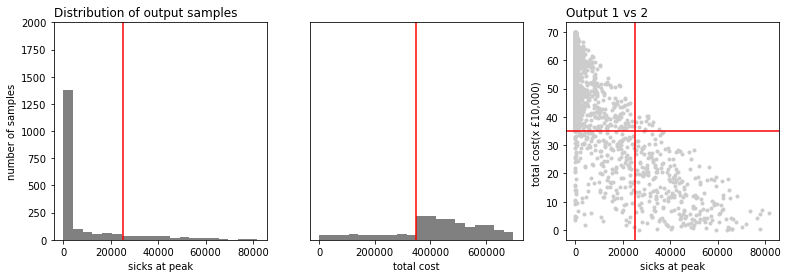

In [34]:
# Plot frequency distribution of outputs:
Y_Labels = ['sicks at peak','total cost']

plt.figure(figsize=[13,4])
plt.subplot(1,3,1)
plt.title('Distribution of output samples', loc='left')
plt.hist(Y1, bins=20, color='grey');
plt.axvline(x=target1, color='r')
plt.ylim((0,N))        
plt.ylabel('number of samples')
plt.xlabel(Y_Labels[0])

plt.subplot(1,3,2)
plt.hist(Y2, bins=20, color='grey');
plt.axvline(x=target2, color='r')
plt.ylim((0,N))
plt.xlabel(Y_Labels[1])
plt.yticks([])

plt.subplot(1,3,3)
plt.title('Output 1 vs 2', loc='left')
plt.plot(Y1,Y2/10000, '.', markerfacecolor='0.8', markeredgecolor='0.8')
plt.xlabel(Y_Labels[0])
plt.ylabel(Y_Labels[1]+ "(x £10,000) ")
plt.axvline(x=target1, color='r')
plt.axhline(y=target2/10000, color='r')

plt.show()

**Comments** For the number of sick individuals at outbreak peak (left), most of the density is to the left of the target (red vertical line), so there are high chances that the target for this output can be achieved. In other words, there are many combinations of parameters that would reach the target against the many different uncertain scenarios. The opposite is true for the total containment cost (middle): the combinations of parameters leading to a total cost less than the target are relatively few, compared to the number of samples that exceed it. 
<br>
From the right plot, we see that several combinations exist where both outputs stay below the set targets (bottom left square). This figure also show the tradeoff between the two outputs, whereby a lower number of sick individuals at peak is generally reached at higher cost. Because of the uncertainty in initial population and recovery time though, the relationship between the two outputs is not univocal, and the same investment (total cost) can lead to different number of sick individuals.
<br>
In general we find that **the answer to the first question** - is it possible to find combinations of decision-relevant parameters that achieve both targets? - is yes, such combinations exist, but given uncertanties, the total cost target has less chances to be met.

#### Calculating Sensitivity indices
Now, we use the input-output samples generated in the previous step to calculate sensitivity indices. We usa a GSA method called *Regional Sensitivity Analysis*, or *Monte Carlo filtering* (more insights about how the methods works to calculate sensitivity indices are given in the last section of this Notebook). We calculate three sets of indices, each measuring the relative importance of the 5 input parameters towards:
- achieving the target for the number of sick individuals at peak (output 1)
- achieving the target for the total costs (output 2)
- achieving both targets simoultaneously (output 1&2 jointly)


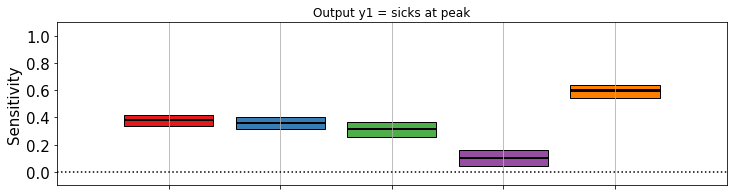

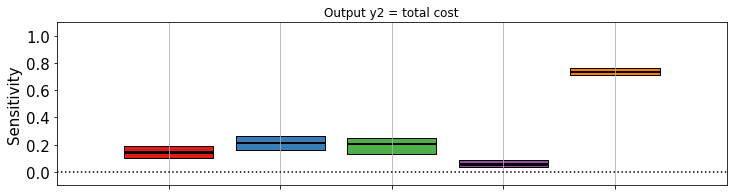

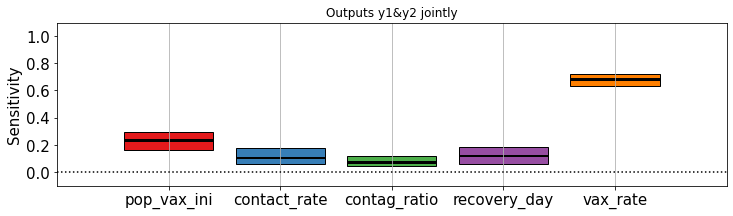

In [35]:
Nboot = 50 # Number of resamples used for bootstrapping
   
plt.figure(figsize=[12,3])
mvd, _, _, idx = RSA_tr.RSA_indices_thres(X, Y1, target1, Nboot=Nboot)
mvd_m, mvd_lb, mvd_ub = aggregate_boot(mvd) # shape (M,)
pf.boxplot1(mvd_m, S_lb=mvd_lb, S_ub=mvd_ub,Y_Label='Sensitivity',X_Labels=['','','','',''])
plt.title("Output y1 = " + Y_Labels[0], loc='center')
plt.show()

mvd, _, _, idx = RSA_tr.RSA_indices_thres(X, Y2, target2, Nboot=Nboot)
mvd_m, mvd_lb, mvd_ub = aggregate_boot(mvd) # shape (M,)
plt.figure(figsize=[12,3])
pf.boxplot1(mvd_m, S_lb=mvd_lb, S_ub=mvd_ub,Y_Label='Sensitivity',X_Labels=['','','','',''])
plt.title("Output y2 = " + Y_Labels[1], loc='center')
plt.show()

Y = np.concatenate((Y1,Y2),axis=1)
target = [target1,target2]
mvd, _, _, idx = RSA_tr.RSA_indices_thres(X, Y, target, Nboot=Nboot)
mvd_m, mvd_lb, mvd_ub = aggregate_boot(mvd) # shape (M,)
plt.figure(figsize=[12,3])
pf.boxplot1(mvd_m, S_lb=mvd_lb, S_ub=mvd_ub,Y_Label='Sensitivity',X_Labels=X_Labels)
plt.title("Outputs y1&y2 jointly", loc='center')
plt.show()

**Comments** In the top plot we see that the three most important factors to keep the number of sick individuals at peak below target are: the vaccination rate (5th parameter), the initial vaccinated population (1st), and the contact rate (2nd). The relative importance of the factors changes with the second output, in fact, from the middle plot we see that the total cost is mostly controlled by the vaccination rate, whereas all other factors have substantially less importance. Last, in the bottom plot we look at the importance of factors in keeping both outputs below their targets. In **response to the second question** set out above - <font color='green'>which of the decision-related parameters are key to achieve the desired outputs?</font> - we can conclude that getting the <font color='green'>vaccination rate</font> right is the most important decision. <br>
Another interesting observation is that the number of days for recovery (4th parameter) has lower importance than the initial vaccinated population (1st) consistenly across all three output definitions. Hence, **in response to the third question** - <font color='blue'>which uncertainties are most influential and should be prioritised for uncertainty reduction?</font> - we conclude that, if we can invest towards collecting more information and reducing uncertainties, it is best to focus our efforts on reducing the uncertainty about the <font color='blue'>inital number of vaccinated individuals</font>, as this parameter is much more influential. Being able to better estimate the recovery days, instead, is not really important in this context, as this parameter does not have much effect towards reaching our targets.

#### Analysing input samples to identify 'robust' decisions

Last, we can determine the most robust combinations of actions to undertake - i.e. actions that will result in reaching the set targets across the largest possible range of uncertainties. 

Once again, the actions are linked to the three decision-relevant parameters: <font color='green'>vaccination rate</font>, <font color='green'>contact rate</font>, and <font color='green'>contagion ratio</font> (in order of importance, as established in previous step). We will use coloured scatter plots to investigate the interactions between these parameters and find combinations that reach the target (both output below their threshold) regardless of the value of the uncertain parameters. 

We can also analyse how these robust actions change with changing level of uncertainty - for instance as we reduce the uncertainty range around the <font color='blue'>initial number of vaccinated individuals</font>. We will not look at the uncertainty in recovery days because, as we established in previous section, it has very little influence on reaching targets. 

In [36]:
def vax_ini_function(vax_ini_min = 0, vax_ini_max = 40000):

    vax_ini_idx = ( X[:,0]> vax_ini_min ) & ( X[:,0]< vax_ini_max )
    Xr = np.zeros((sum(vax_ini_idx),M))
    for i in range(5):
        Xr[:,i]=X[vax_ini_idx,i]
    Y1r = Y1[vax_ini_idx]
    Y2r = Y2[vax_ini_idx]
  
    Yr = np.concatenate((Y1r,Y2r),axis=1)
    target = [target1,target2]
    mvd, _, _, idx = RSA_tr.RSA_indices_thres(Xr, Yr, target)

    plt.figure(figsize=[15,4])

    plt.subplot(1,3,1)
    plt.plot(Xr[:, 4], Xr[:, 1]   , '.', markerfacecolor='0.8', markeredgecolor='0.8')
    plt.plot(Xr[idx,4], Xr[idx, 1], '.', markerfacecolor='r', markeredgecolor='r')
    plt.xlabel(X_Labels[4])
    plt.ylabel(X_Labels[1])
    plt.title("Combinations of actions (red) that will keep both outputs below target for given range of vax_ini", loc='left')
    
    plt.subplot(1,3,2)
    plt.plot(Xr[:, 4], Xr[:, 2]   , '.', markerfacecolor='0.8', markeredgecolor='0.8')
    plt.plot(Xr[idx,4], Xr[idx, 2], '.', markerfacecolor='r', markeredgecolor='r')
    plt.xlabel(X_Labels[4])
    plt.ylabel(X_Labels[2])

    plt.subplot(1,3,3)
    plt.plot(Xr[:, 1], Xr[:, 2]   , '.', markerfacecolor='0.8', markeredgecolor='0.8')
    plt.plot(Xr[idx,1], Xr[idx, 2], '.', markerfacecolor='r', markeredgecolor='r')
    plt.xlabel(X_Labels[1])
    plt.ylabel(X_Labels[2])

    plt.show()

interact(vax_ini_function, vax_ini_min = (0,40000,1000), vax_ini_max = (0,40000,1000));

interactive(children=(IntSlider(value=0, description='vax_ini_min', max=40000, step=1000), IntSlider(value=400…

**Comments** The first plot on the left shows tht there is a strong interaction between contact rate and vaccination rate, hence it is important to coordinate actions relevant to these parameters in order to ensure reaching the targets. We also observe that if we can reduce the uncertainty in the initial number of vaccinated individuals, the spread of the combinations of actions that may achieve the target is reduced, and the relationship between vaccination rate and contact rate becomes clearer and clearer.

#### Advanced steps: investigating how Regional Sensitivity Analysis works
This last section is for those who want to dig deeper in how sensitivity indices are derived when using Regional Sensitivity Analysis (for more background on this method, see Spear and Hornberger 1980 or Pianosi et al. 2016) and the impact of varying the target threshold on sensitivity results. 

In [33]:
def rsa_function(peak_target = target1, cost_target = target2):
    # Use the function RSA_indices_thres to split into behavioural (Y<threshold)
    # and non-behavioural (Y>threshold) sample:
    Y = np.concatenate((Y1,Y2),axis=1)
    threshold = [peak_target,cost_target]
    Nboot = 50 # Number of resamples used for bootstrapping
    mvd, _, _, idx = RSA_tr.RSA_indices_thres(X, Y, threshold, Nboot=Nboot)
    mvd_m, mvd_lb, mvd_ub = aggregate_boot(mvd) # shape (M,)

    plt.figure(figsize=[15,8])
    # Scatter plots of Output 1 versus each input parameter
    for i in range(M):
        plt.subplot(3,M,i+1)
        plt.plot(X[:, i], Y1/1000  , '.', markerfacecolor='0.8', markeredgecolor='0.8')
        plt.plot(X[idx,i], Y1[idx, :]/1000, '.', markerfacecolor='r', markeredgecolor='r')
        if i==0:
            plt.ylabel(Y_Labels[0] + " (x1000)")
    # Scatter plots of Output 2 versus each input parameter
    for i in range(M):
        plt.subplot(3,M,M+i+1)
        plt.plot(X[:, i], Y2/1000  , '.', markerfacecolor='0.8', markeredgecolor='0.8')
        plt.plot(X[idx,i], Y2[idx, :]/1000, '.', markerfacecolor='r', markeredgecolor='r')
        if i==0:
            plt.ylabel(Y_Labels[1] + " (£x1000)")
    # Empirical distribution of each parameter in the behavioural and non-behavioural set        
    for i in range(M):
        # Approximate behavioural and non-behavioural distributions:
        Xb = X[idx, :]
        Xnb = X[~idx, :]
        xx = np.unique(sorted(X[:, i]))
        CDFb  = empiricalcdf(Xb[:, i], xx)
        CDFnb = empiricalcdf(Xnb[:, i], xx)
        # Plot CDFs:
        plt.subplot(3,M,M+M+i+1)
        plt.plot(xx, CDFb , color='r')
        plt.plot(xx, CDFnb, color='0.8')
        plt.xlabel(X_Labels[i])
        if i==0:
            plt.ylabel("distribution")
            plt.legend(['on target','off target'])
    plt.show()

    # The sensitivity indices with their 95% confidence intervals:
    plt.figure(figsize=[12,3])
    pf.boxplot1(mvd_m, S_lb=mvd_lb, S_ub=mvd_ub, X_Labels=X_Labels,Y_Label='Sensitivity')
    # plt.title("KS with 95%% CI, N = %d" % N + ", " + Y_Label + " = %2.2f" % threshold)
    plt.show()
interact(rsa_function, peak_target = (target1-20000,target1+20000,100), cost_target = (250000, 400000, 100));


interactive(children=(IntSlider(value=25000, description='peak_target', max=45000, min=5000, step=100), IntSli…

## References

Pianosi et al. (2015). A Matlab toolbox for Global Sensitivity Analysis’. Env. Mod. & Soft., 70, 80-85.

Pianosi et al. (2016). Sensitivity analysis of environmental models: A systematic review with practical workflow, Env. Mod. & Soft.e, 79, 214-232.

Spear and Hornberger (1980). Eutrophication in peel inlet. II. Identification of critical uncertainties via generalized sensitivity analysis, Water Res., 14, 43-49.
